In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision.transforms import v2
from torchvision.io import decode_image

import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose

import dr_gen.utils.data as du

%load_ext autoreload
%autoreload 2

### Setup Config & Helpers

In [2]:
root_path = "/Users/daniellerothermel/drotherm"
repo_path = f"{root_path}/repos/dr_gen/"

In [3]:
with initialize(config_path=f"../scripts/conf/", version_base=None):
    cfg = compose(
        config_name="config.yaml",
        overrides=[
            f"paths.root={root_path}",
            f"data.num_workers=4",
        ],
    )

In [4]:
print(OmegaConf.to_yaml(OmegaConf.to_container(cfg, resolve=True)))

paths:
  root: /Users/daniellerothermel/drotherm
  data: /Users/daniellerothermel/drotherm/data/dr_gen
  logs: /Users/daniellerothermel/drotherm/logs/dr_gen
  dataset_cache_root: /Users/daniellerothermel/drotherm/data/dr_gen/cifar10/
data:
  name: cifar10
  num_workers: 4
  cache_dataset: true
  download: true



In [5]:
torch.manual_seed(1)

In [27]:
# Copy helper from https://github.com/pytorch/vision/blob/main/gallery/transforms/helpers.py
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

### Test Out Dataloading

#### PIL images

In [28]:
# Test loading dataset with PIL images
cifar10_train_pil = du.get_dataset(
    cfg.data, cfg.paths, train=True, as_pil=True,
)
cifar10_train_pil

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /Users/daniellerothermel/drotherm/data/dr_gen/cifar10/
    Split: Train

In [29]:
sample_pil = cifar10_train_pil[0]
sample_pil

(<PIL.Image.Image image mode=RGB size=32x32>, 6)

In [34]:
print(f"{type(sample_pil[0]) = }")

type(sample_pil[0]) = <class 'PIL.Image.Image'>


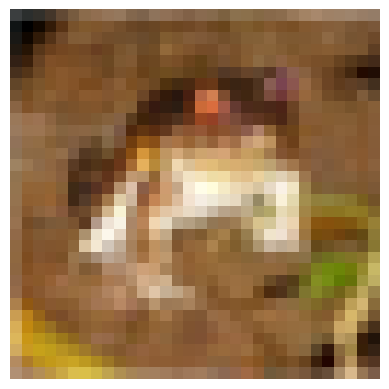

In [35]:
plt.imshow(sample_pil[0])
plt.axis("off")
plt.show()

#### TV Tensor Images

In [30]:
# Test loading dataset with tensors
cifar10_train_tvt = du.get_dataset(
    cfg.data, cfg.paths, train=True, as_pil=False,
)
cifar10_train_tvt

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /Users/daniellerothermel/drotherm/data/dr_gen/cifar10/
    Split: Train
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
           )

In [31]:
sample_tvt = cifar10_train_tvt[0]
sample_tvt

(Image([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.1961, 

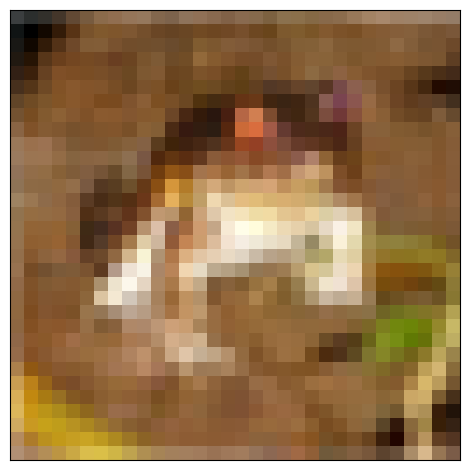

In [36]:
plot([sample_tvt[0]])

### TBD